In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, 
    precision_score, recall_score, 
    roc_curve, auc
)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [40]:
def label_delay(delay):
    if delay <= 15:
        return 'on-time'
    elif delay <= 45:
        return 'late'
    else:
        return 'very-late'

In [41]:
df = pd.read_csv('Combined_Flights_2022.csv', nrows=100000)

In [42]:
df['DelayLabel'] = df['ArrDelayMinutes'].apply(label_delay)

In [43]:
relevant_columns = ['Airline', 'Origin', 'Dest', 
                    'DepTime', 'ArrTime', 'DelayLabel', 
                    'Distance', 'DayOfWeek', 'DayofMonth', 'Quarter']

df = df[relevant_columns]

In [44]:
df = pd.get_dummies(df, columns=['Airline', 'Origin', 'Dest'], dtype=int)

In [45]:
scaler = StandardScaler()
columns_to_normalize = ["DepTime", "ArrTime", 'Distance']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [46]:
# Tæl antallet af rækker før dropna()
rows_before = len(df)
df.dropna(inplace=True)
rows_after = len(df)
rows_removed = rows_before - rows_after
print(f"Fjernet {rows_removed} rækker.")

Fjernet 1957 rækker.


In [47]:
label = df.pop("DelayLabel")

In [48]:
train_x, test_x, train_y, test_y = train_test_split(df, label, stratify=label, test_size=0.20, random_state=1)

In [49]:
#gnb = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=-1)
gnb = LogisticRegression()
model = gnb.fit(train_x, train_y)


/Users/dannihedegaarddahl/anaconda3/envs/flightdata/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
predicted_values = gnb.predict(test_x)

In [51]:
predicted_proba = gnb.predict_proba(test_x)

def classify(proba):
    print(proba)
    if proba > 0.13:
        return 'very-late'
    elif proba <= 0.13 and proba >= 0.11:
        return 'late'
    else:
        return 'on-time'

predictions_from_proba = [classify(proba) for proba in predicted_proba]

[0.30497993 0.43545302 0.25956705]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [54]:
acc = accuracy_score(test_y, predicted_values)
conf_matrix = confusion_matrix(test_y, predicted_values)
prec = precision_score(test_y, predicted_values, average='weighted')
rec = recall_score(test_y, predicted_values, average='weighted')

In [55]:
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")

# Print Confusion Matrix with labels
classes = model.classes_
print("Confusion Matrix:")
print(f"Labels: {classes}")
print(conf_matrix)

Accuracy: 0.7298179407414963
Precision: 0.6531262647229066
Recall: 0.7298179407414963
Confusion Matrix:
Labels: ['late' 'on-time' 'very-late']
[[  200  2961   132]
 [  185 13877    98]
 [  195  1727   234]]


In [ ]:
acc = accuracy_score(test_y, predictions_from_proba)
conf_matrix = confusion_matrix(test_y, predictions_from_proba)
prec = precision_score(test_y, predictions_from_proba, average='weighted')
rec = recall_score(test_y, predictions_from_proba, average='weighted')

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [ ]:
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")

# Print Confusion Matrix with labels
classes = model.classes_
print("Confusion Matrix:")
print(f"Labels: {classes}")
print(conf_matrix)

Accuracy: 0.8214179494805501
Precision: 0.793001333399986
Recall: 0.8214179494805501
Confusion Matrix:
Labels: ['late' 'on-time' 'very-late']
[[ 1754  9178   616]
 [  664 74912   390]
 [  824  5741  3428]]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


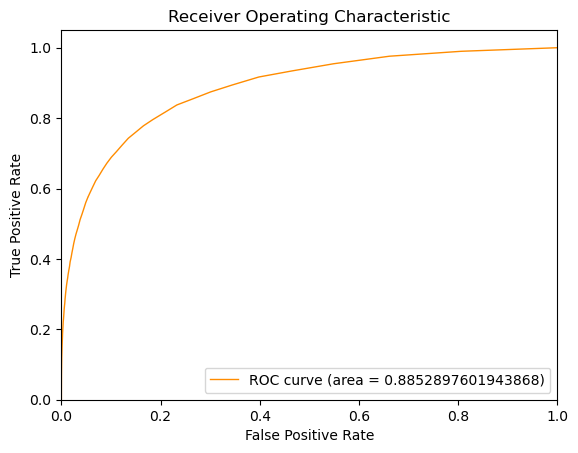

In [ ]:
# For demonstration, let's just consider the 'very-late' label for ROC
if 'very-late' in model.classes_:
    pos_label_idx = list(model.classes_).index('very-late')
    fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_x)[:, pos_label_idx], pos_label='very-late')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#Locate cop off point (threshold) with highest TPR and lowest FPR
fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_x)[:, pos_label_idx], pos_label='very-late')

i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr - (1 - fpr), index=i), 'threshold' : pd.Series(_, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

opt_cop = round(list(roc_t['threshold'])[0], 2)
opt_cop

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.11

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


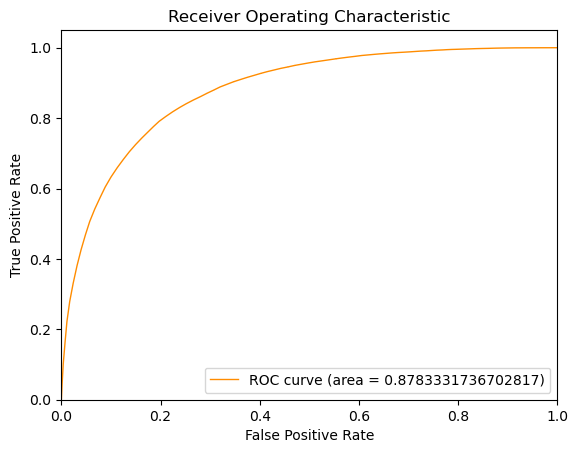

In [ ]:
# For demonstration, let's just consider the 'very-late' label for ROC
if 'on-time' in model.classes_:
    pos_label_idx = list(model.classes_).index('on-time')
    fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_x)[:, pos_label_idx], pos_label='on-time')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#Locate cop off point (threshold) with highest TPR and lowest FPR
fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_x)[:, pos_label_idx], pos_label='on-time')

i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr - (1 - fpr), index=i), 'threshold' : pd.Series(_, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

opt_cop = round(list(roc_t['threshold'])[0], 2)
opt_cop

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.07

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


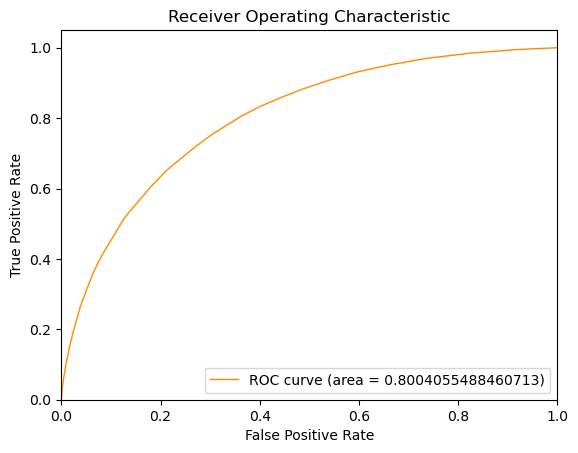

In [ ]:
# For demonstration, let's just consider the 'very-late' label for ROC
if 'late' in model.classes_:
    pos_label_idx = list(model.classes_).index('late')
    fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_x)[:, pos_label_idx], pos_label='late')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#Locate cop off point (threshold) with highest TPR and lowest FPR
fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_x)[:, pos_label_idx], pos_label='late')

i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr - (1 - fpr), index=i), 'threshold' : pd.Series(_, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

opt_cop = round(list(roc_t['threshold'])[0], 2)
opt_cop

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


0.13